In [1]:
# Alle imports
from model_building import build_model
import keras_tuner
import pandas as pd
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
import random

Variablen definieren:

In [2]:
path = '../data/raw/'
filenames = os.listdir(path)
filenames.remove('.gitkeep')
image_size = (150, 150)
val_split = 0.1

Funktionen:

In [3]:
def get_label(string):
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[0:-1])
    return string


In [4]:
def preprocessing(path, image_size, val_split):
    """
    path:       to directory that contains the image files,
    val_split:  specified ratio of validation to training data (= percent of all images taken for validation)
    image_size: of the images (after resizing by the data generator, needs to be the same in the model)
    
    returns training and validation DataGenerator
    """
    filenames = os.listdir(path)
    filenames.remove('.gitkeep')
    df = pd.DataFrame(filenames, columns=['Filenames'])
    
    df['Label'] = df['Filenames'].apply(lambda x: get_label(x))
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = val_split)
    train_generator = datagen.flow_from_dataframe(df,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='training')
    validation_generator = datagen.flow_from_dataframe(df,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='validation')
    
    return train_generator, validation_generator

Preprocessing ausführen:

In [5]:
train_generator, validation_generator = preprocessing(path, image_size, val_split)

Found 36000 validated image filenames belonging to 50 classes.
Found 4000 validated image filenames belonging to 50 classes.


Random Beispielbild anzeigen:

Sample image:


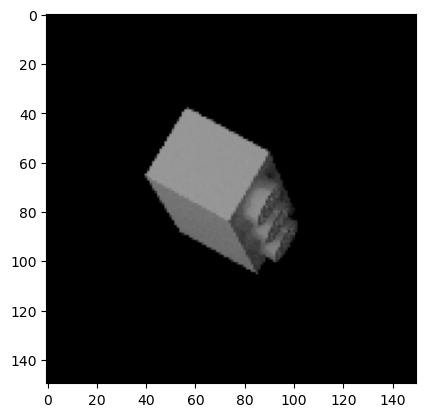

In [6]:
print("Sample image:")
img_files = [os.path.join(path, f) for f in filenames]
img_path = random.choice(img_files)
img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.show()

## Definiere Tuner
Der Tuner wählt Hyperparameter und verwendet diese um ein Model zu bauen.
Die Ergebnisse, inkl. des besten Model werden in den 'experiments' Ordner geschrieben.

In [8]:
# TODO wähle ggf. andere Tunerklasse
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="../experiments",
    project_name="Hyperparametertuning",
)

# run tuner
# The parameters passed to search() are passed to model.fit()
# TODO add training and validation data
tuner.search(train_generator,
             epochs = 20,
             validation_data = validation_generator
            )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
96                |?                 |filter_total_0
3                 |?                 |kernel_size
5                 |?                 |convolution_layers_total
64                |?                 |filter_total_1
3                 |?                 |kernel_size_1
80                |?                 |filter_total_2
4                 |?                 |kernel_size_2
9                 |?                 |dense_layers_total
96                |?                 |units_0
True              |?                 |dropout_0

Epoch 1/20
1001/1125 [=========================>....] - ETA: 12s - loss: 3.5853 - accuracy: 0.0437

KeyboardInterrupt: 

Imagegenerator kann die Bilder aus ihren Unterordner aus data/interim laden. Wenn möglich Bilder in schwarz/weiß und 150x150.

Funktion, die die Outputs der Convolution-Layer visualisiert (kopiert aus C2_W1_Lab1):

In [4]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
img_files = [os.path.join(path, f) for f in filenames]
img_path = random.choice(img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

NameError: name 'model' is not defined